# 02/27/2024 - This notebook extracts the spectra from the datacube within several factors of the effective radius to test aperture-integrated kinematics.

In [1]:
# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import io
from os import path
import glob
#import Image from PIL
from PIL import Image
import dill as pickle

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
# slacs_kcwi_kineamtics
from slacs_kcwi_kinematics import slacs_kcwi_kinematics

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC

c = 299792.458 # km/s


In [19]:
# specify object directory and name

#################################################
# date and number of initial kinematics run e.g. 2023-02-28_2
date_of_kin = '2024_02_15'
date_of_mge = '2023-02-28_2' # The MGEs I did for these kinematics will still be good. don't need to redo them
###################################################################################################################################

#------------------------------------------------------------------------------
# Directories and files

# data directory
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/'
hst_dir = '/data/raw_data/HST_SLACS_ACS/kcwi_kinematics_lenses/'
tables_dir = f'{data_dir}tables/'
# get the revised KCWI sigmapsf
sigmapsf_table = pd.read_csv(f'{tables_dir}kcwi_sigmapsf_estimates.csv')
mosaics_dir = f'{data_dir}mosaics/'
kinematics_full_dir = f'{data_dir}kinematics/'
kinematics_dir =f'{kinematics_full_dir}{date_of_kin}/'
mge_dir = f'{kinematics_full_dir}{date_of_mge}/'
print(f'Outputs will be in {kinematics_dir}')
print()

# target SN for voronoi binning
#vorbin_SN_targets = np.array([10, 15, 20])
vorbin_SN_targets = np.array([15])
sps_name = 'xshooter'

#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]

#################################################


paper_table = pd.read_csv(f'{tables_dir}paper_table_022224.csv')

Outputs will be in /data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/kinematics/2024_02_15/



# J0029

In [3]:

obj_name = obj_names[0]

print('################################################################################################################')
print('################################################################################################################')
print('################################################################################################################')
print('################################################################################################################')
print('################################################################################################################')
print()
print(obj_name)
print()
print('################################################################################################################')
print('################################################################################################################')
print('################################################################################################################')
print('################################################################################################################')
print('################################################################################################################')
    
kin_dir = f'{kinematics_dir}{obj_name}/'

# get the kinematics from the january date
with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
    kin_data = pickle.load(file)

################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################

SDSSJ0029-0055

################################################################################################################
################################################################################################################
################################################################################################################
###############################################################################

# Create a function that will simulate the aperture kinematics in factors of reff


In [4]:
from scipy.ndimage import gaussian_filter

In [12]:
datacube = kin_data.cropped_datacube
aperture_factors = np.arange(0.1, 1.6, 0.1)

In [13]:
def extract_aperture_kinematics (self, data_seeing_FWHM=None, simulated_seeing_FWHM=None, aperture_radius=None, convolve=False, fit_global_template=False, plot=False):
    
    '''
    This function will simulate e.g. SDSS aperture kinematics from the datacube for comparison.
    
    Parameters:
    
        data_seeing_FWHM - float
            The FWHM seeing of the data, e.g. KCWI is ~ 0.8 arcsecond seeing
    
        simulated_seeing_FWHM - float
            The FWHM seeing you want to emulate in arcsec, e.g. SDSS is ~ 2.0 arcsecond seeing
            
        aperture_radius - float
            Aperture size in arcsec, e.g. SDSS is 1.5 arcsecond aperture
            
    Returns
    
    '''
    
    # take the cropped datacube from the class
    datacube = self.cropped_datacube.copy()
    
    # convolve with the difference in the PSF between the data and the desired simulation PSF
    if convolve:
        
        print('Convolving with simulated seeing.')
        
        if plot:
            plt.imshow(np.nansum(datacube, axis=0), origin='lower')
            plt.title('Before convolution')
            plt.pause(1)
        
        # convert FWHM to std of the PSF
        sigma_data = data_seeing_FWHM / 2.355
        sigma_sim = simulated_seeing_FWHM / 2.355
        # take the difference in order to convolve
        sigma_diff = np.sqrt(sigma_sim**2 - sigma_data**2)
        
        # go through all wavelength bins and convolve
        for i, wavelength in enumerate(datacube):
            datacube[i] = gaussian_filter(wavelength, sigma_diff)
            
        if plot:
            plt.imshow(np.nansum(datacube, axis=0), origin='lower')
            plt.title('After convolution')
            plt.pause(1)
            
    # take the pixels within a given aperture radius and integrate
    img_size = datacube.shape[1]
    
    # get radius of pixels
    pixels = np.arange(img_size) - img_size//2 # subtract 21 pixels, center don't know which is x and which is y, but doesn't matter for R
    pixel_xx, pixel_yy = np.meshgrid(pixels, pixels) # make a grid
    
    # calculate radius of each pixel
    pixel_radii = np.sqrt(pixel_xx**2 + pixel_yy**2)*0.1457 # arcsec
    
    # if they are in the aperture radius
    in_aperture = (pixel_radii <= aperture_radius)
    
    # take the pixels in the aperture and sum them
    aperture_pixels = datacube[:,in_aperture]
    
    # integrated spectrum
    aperture_spectrum = np.nansum(aperture_pixels, axis=1)
    
    # log rebin the integrated spectrum
    # rebin to log wavelengths and calculate velocity scale (resolution)
    aperture_spectrum, rest_wave_log, central_velscale = \
                                            ppxf_util.log_rebin(self.rest_wave_range, aperture_spectrum)
    
    # now fit with the templates
    # set up galaxy, background source, and wavelengths
    galaxy = np.copy(aperture_spectrum)
    background_source = np.copy(self.background_spectrum)
    wavelengths = np.exp(rest_wave_log)

    # cut the data, background source, and wavelengths to the wave_min and wave_max we specified
    cut_lo = self.wave_min*0.9
    cut_hi = self.wave_max*1.1
    galaxy = galaxy[wavelengths>cut_lo]
    background_source = background_source[wavelengths>cut_lo]
    wavelengths = wavelengths[wavelengths>cut_lo]
    galaxy = galaxy[wavelengths<cut_hi]
    background_source = background_source[wavelengths<cut_hi]
    wavelengths = wavelengths[wavelengths<cut_hi]

    # take the log of the now-cut wavelength array
    log_wavelengths = rest_wave_log

    # take range of template wavelengths
    lam_range_temp = np.array([self.templates_wave[0], self.templates_wave[-1]])

    # keep only the good pixels, after de-redshift, the initial redshift is zero.
    goodPixels = ppxf_util.determine_goodpixels(log_wavelengths, lam_range_temp, 0)

    # find the indices of wave_min and wave_max in wavelengths array
    ind_min = find_nearest(wavelengths, self.wave_min)
    ind_max = find_nearest(wavelengths, self.wave_max)

    # mask the appropriate wavelengths and gas emission lines
    mask=goodPixels[goodPixels<ind_max]
    mask = mask[mask>ind_min]
    boolen = ~((2956 < mask) & (mask < 2983))  # mask the Mg II
    mask = mask[boolen]
    boolen = ~((2983 < mask) & (mask < 3001))  # mask the Mg II
    mask = mask[boolen]

    #####
    # create a noise array # Assume constant noise per AA
    noise_array = np.full_like(galaxy, self.noise) 

    # some setup, starting guesses
    vel = c*np.log(1 + 0)   # eq.(8) of Cappellari (2017)
    start = [vel, 250.]  # (km/s), starting guess for [V, sigma]
    #bounds = [[-500, 500],[50, 450]] # not necessary
    t = clock()

    # fit with ppxf
    pp = ppxf(self.templates, # templates for fitting
              galaxy,#self.central_spectrum,  # spectrum to be fit
              noise_array,
              self.central_velscale, # resolution
              start, # starting guess
              plot=False, # no need to plot here, will plot after
              moments=2, # VD and V, no others
              goodpixels=mask,#self.mask, # mask we made
              degree=self.degree, # degree of polynomial we specified
              velscale_ratio=self.velscale_ratio, # resolution of templates wrt. data
              sky=background_source,#self.background_spectrum, # background source spectrum
              lam=wavelengths,#self.rest_wave, # wavelengths for fitting
              lam_temp=self.templates_wave, # wavelenghts of templates
             )

    # take the fit as attributes for future
    aperture_spectrum_ppxf = pp

    # correct for the difference in resolution if the template resolution is larger than the data resolution
    aperture_spectrum_VD = np.sqrt(pp.sol[1]**2 - self.resolution_difference)
    aperture_spectrum_dVD = pp.error[1]*np.sqrt(pp.chi2)
    
    print('Aperture VD', aperture_spectrum_VD)
    
    # show results of fit
    print("Formal errors:")
    print("     dV    dsigma   dh3      dh4")
    print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))
    print('Elapsed time in pPXF: %.2f s' % (clock() - t))
    
    if plot:
        #plot the fit
        # model
        model = pp.bestfit
        # background source
        background = pp.sky[:,0]*pp.weights[-1]#self.background_spectrum * pp.weights[-1]
        # data
        data = pp.galaxy

        # linearize the wavelengths for plotting
        log_axis = wavelengths#self.rest_wave
        lin_axis = np.linspace(
                                wavelengths[0],
                                wavelengths[-1],
                                log_axis.size#data.size
                              )
            #self.rest_wave_range[0], self.rest_wave_range[1], data.size)

        assert len(log_axis) == len(lin_axis) == len(background), \
            f"len(log_axis), len(lin_axis), len(background): {len(log_axis), len(lin_axis), len(background)}"

        # rebin in linear space
        back_lin = de_log_rebin(log_axis, background, lin_axis) # background source fit
        model_lin = de_log_rebin(log_axis, model, lin_axis) # ppxf model
        data_lin = de_log_rebin(log_axis, data, lin_axis) # data
        noise_lin = data_lin - model_lin # noise

        # find the indices of the restframe wavelengths that are closest to the min and max we want for plot limits
        plot_ind_min = find_nearest(lin_axis, self.wave_min)
        plot_ind_max = find_nearest(lin_axis, self.wave_max)

        # make the figure
        plt.figure(figsize=(8,6))

        # plot the spectra, noise, etc
        plt.plot(lin_axis, data_lin, 'k-', label='data')
        plt.plot(lin_axis, model_lin, 'r-', label='model (lens+background)')
        plt.plot(lin_axis, data_lin - back_lin, 'm-',
                 label='remove background source from data', alpha=0.5) # if there is a background source to remove
        plt.plot(lin_axis, back_lin + np.full_like(back_lin, 0.9e-5), 'c-',label='background source', alpha=0.7)
        plt.plot(lin_axis, noise_lin + np.full_like(back_lin, 0.9e-5), 'g-',
                 label='noise (data - best model)', alpha=0.7)

        # set labels, axes, etc
        plt.legend(loc='best')
        plt.ylim(np.nanmin(noise_lin[plot_ind_min:plot_ind_max])/1.1, np.nanmax(data_lin[plot_ind_min:plot_ind_max])*1.1)
        plt.xlim(self.wave_min, self.wave_max)
        plt.xlabel('wavelength (A)')
        plt.ylabel('relative flux')
        plt.title(f'Velocity dispersion - {int(aperture_spectrum_VD)} km/s')
        plt.show()
        plt.pause(1)
        
    # save the global template if this is going to be that fit
    if fit_global_template:
        # number of templates
        self.nTemplates = pp.templates.shape[1]
        # global_template is what we use to fit the bins
        self.global_template = pp.templates @ pp.weights[:self.nTemplates]
        self.global_template_wave = pp.lam_temp
        
    return aperture_spectrum_ppxf, aperture_spectrum_VD, aperture_spectrum_dVD
    

# Add the function dynamically to the class

In [14]:
from types import MethodType

In [15]:
kin_data.extract_aperture_kinematics = MethodType(extract_aperture_kinematics, kin_data)

# Need additional pieces that will be in the slacs_kcwi_kinematics.py module

In [16]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import pathlib # to create directory

from ppxf.ppxf import ppxf
from pathlib import Path
from scipy import ndimage
from urllib import request
from scipy import ndimage
from time import perf_counter as clock
from scipy import interpolate
from astropy.visualization import simple_norm
import astropy.units as u
from vorbin.voronoi_2d_binning import voronoi_2d_binning
import pyregion

import ppxf.ppxf_util as ppxf_util
from os import path
ppxf_dir = path.dirname(path.realpath(ppxf_util.__file__))
import ppxf.sps_util as sps_util

from time import perf_counter as clock
c = 299792.458 # km/s

##############
# Utility functions

def register_sauron_colormap():
    """
    Regitsr the 'sauron' and 'sauron_r' colormaps in Matplotlib

    """
    cdict = {'red':[(0.000,   0.01,   0.01),
                 (0.170,   0.0,    0.0),
                 (0.336,   0.4,    0.4),
                 (0.414,   0.5,    0.5),
                 (0.463,   0.3,    0.3),
                 (0.502,   0.0,    0.0),
                 (0.541,   0.7,    0.7),
                 (0.590,   1.0,    1.0),
                 (0.668,   1.0,    1.0),
                 (0.834,   1.0,    1.0),
                 (1.000,   0.9,    0.9)],
        'green':[(0.000,   0.01,   0.01),
                 (0.170,   0.0,    0.0),
                 (0.336,   0.85,   0.85),
                 (0.414,   1.0,    1.0),
                 (0.463,   1.0,    1.0),
                 (0.502,   0.9,    0.9),
                 (0.541,   1.0,    1.0),
                 (0.590,   1.0,    1.0),
                 (0.668,   0.85,   0.85),
                 (0.834,   0.0,    0.0),
                 (1.000,   0.9,    0.9)],
         'blue':[(0.000,   0.01,   0.01),
                 (0.170,   1.0,    1.0),
                 (0.336,   1.0,    1.0),
                 (0.414,   1.0,    1.0),
                 (0.463,   0.7,    0.7),
                 (0.502,   0.0,    0.0),
                 (0.541,   0.0,    0.0),
                 (0.590,   0.0,    0.0),
                 (0.668,   0.0,    0.0),
                 (0.834,   0.0,    0.0),
                 (1.000,   0.9,    0.9)]
         }

    rdict = {'red':[(0.000,   0.9,    0.9),
                 (0.170,   1.0,    1.0),
                 (0.336,   1.0,    1.0),
                 (0.414,   1.0,    1.0),
                 (0.463,   0.7,    0.7),
                 (0.502,   0.0,    0.0),
                 (0.541,   0.3,    0.3),
                 (0.590,   0.5,    0.5),
                 (0.668,   0.4,    0.4),
                 (0.834,   0.0,    0.0),
                 (1.000,   0.01,   0.01)],
        'green':[(0.000,   0.9,    0.9),
                 (0.170,   0.0,    0.0),
                 (0.336,   0.85,   0.85),
                 (0.414,   1.0,    1.0),
                 (0.463,   1.0,    1.0),
                 (0.502,   0.9,    0.9),
                 (0.541,   1.0,    1.0),
                 (0.590,   1.0,    1.0),
                 (0.668,   0.85,   0.85),
                 (0.834,   0.0,    0.0),
                 (1.000,   0.01,   0.01)],
         'blue':[(0.000,   0.9,    0.9),
                 (0.170,   0.0,    0.0),
                 (0.336,   0.0,    0.0),
                 (0.414,   0.0,    0.0),
                 (0.463,   0.0,    0.0),
                 (0.502,   0.0,    0.0),
                 (0.541,   0.7,    0.7),
                 (0.590,   1.0,    1.0),
                 (0.668,   1.0,    1.0),
                 (0.834,   1.0,    1.0),
                 (1.000,   0.01,   0.01)]
         }

    sauron = colors.LinearSegmentedColormap('sauron', cdict)
    sauron_r = colors.LinearSegmentedColormap('sauron_r', rdict)
    plt.register_cmap(cmap=sauron)
    plt.register_cmap(cmap=sauron_r)

def de_log_rebin(delog_axi, value, lin_axi):
    '''
    :param delog_axi: input the value by np.exp(logLam1)
    :param value: flux at the location of np.exp(logLam1) array
    :param lin_axi: linear space in wavelength that we want to intepolate
    :return: flux at the location of linear space in wavelength
    '''
    inte_sky = interpolate.interp1d(delog_axi, value, bounds_error=False)
    sky_lin = inte_sky(lin_axi)
    return sky_lin

def getMaskInFitsFromDS9reg(input,shape,hdu):
    '''
    Returns 2D pixel mask from .reg file created in DS9.
    '''
    r = pyregion.open(input)
    mask = r.get_mask(shape=shape,hdu=hdu)
    return mask

def poisson_noise(T_exp, gal_lin, std_bk_noise, per_second=False):
    '''
    This means that the pixel uncertainty of pixel i (sigma_i) is obtained
    from the science image intensity pixel i (d_i) by:
    sigma_i^2 = scale * (d_i)^power + const
    The first term represents noise from the astrophysical source, and the
    second term is background noise (including read noise etc.).
    When power=1 and scale=1 with d_i in counts, the astrophysical source noise
    (=1*d_i^1=d_i) is Poisson. Suyu 2012 and Suyu et al. 2013a have somels

    description of this.

    To construct the weight map using the esource_noise_model:
    -- set power=1
    -- obtain const by estimating the variance of the background (i.e., const = sigma_bkgd^2 from an empty part of of the science image).
    -- the scale is 1 if d_i is in counts, but otherwise it needs to account for exposure time if d_i is in counts per second.

    Since the unit of the KCWI data is flux/AA (see fits header),
    I need to compute scale with appropriate multiplications/divisions of
    the exposure time (T_exp).  In this case, scale should be 1/texp so that
    the units are in counts/sec for sigma_i^2 (since d_i needs to be
    multiplied by texp to get to counts for Poisson noise estimation,
    but then divided by texp^2 to get to counts/sec).

    :param T_exp: the total exposure time of the dataset
    :param gal_lin: input data
    :param bk_noise: standard deviation of the background noise
    :param per_second: set True if it is in the unit of counts/second
    :return: poisson noise
    '''

    const = std_bk_noise**2
    if per_second:
        scale= 1/T_exp
        sigma2 = scale * (gal_lin) + const
    else:
        scale = 1.
        sigma2 = scale * (gal_lin) + const

    if (sigma2<0).any():
        sigma2[sigma2 < 0] = const

    if np.isnan(sigma2).any():
        sigma2[np.isnan(sigma2)] = const

    poisson_noise = np.sqrt(sigma2)

    return poisson_noise

def find_nearest(array, value):
    '''
    :param array: wavelength array
    :param value: wavelength that we want to get the index
    :return: the index of the wavelength
    '''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Now do it with aperture factors, no convolution.

In [43]:
data_seeing_FWHM = 0.8 # arcsec
simulated_seeing_FWHM = 0#2.0
#aperture_radius = 1.5
convolve=False
fit_global_template=False
plot=True


array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5])

 Best Fit:       Vel     sigma
 comp.  0:       289       224
chi2/DOF: 0.8794; DOF: 2017; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 15/629
Aperture VD 223.66959326122267
Formal errors:
     dV    dsigma   dh3      dh4
       3     3.2
Elapsed time in pPXF: 2.22 s


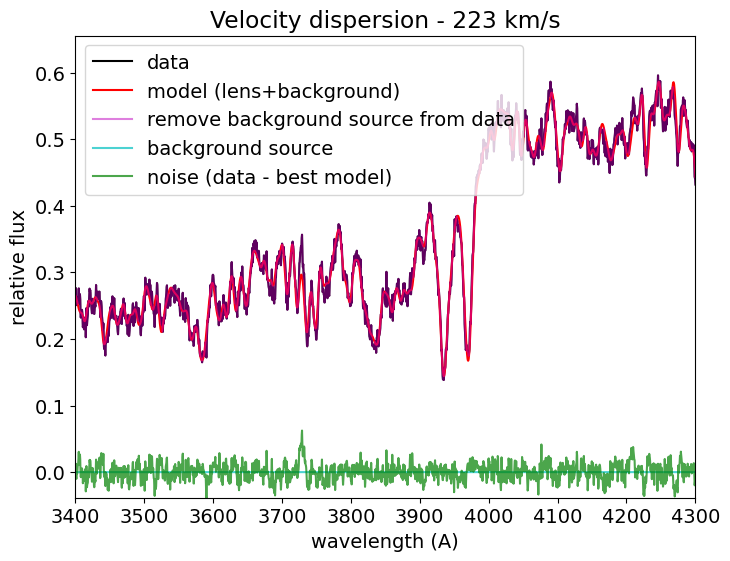

 Best Fit:       Vel     sigma
 comp.  0:       288       217
chi2/DOF: 5.414; DOF: 2017; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 12/629
Aperture VD 216.86522858699732
Formal errors:
     dV    dsigma   dh3      dh4
     2.7       3
Elapsed time in pPXF: 2.31 s


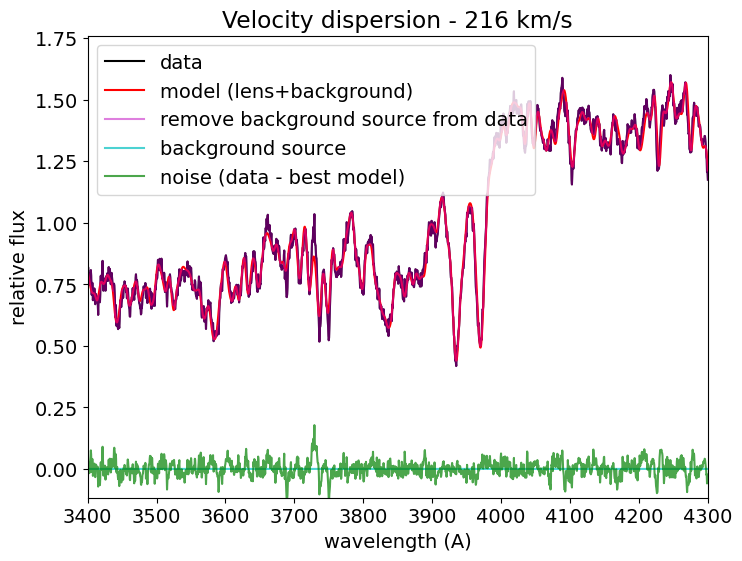

 Best Fit:       Vel     sigma
 comp.  0:       287       215
chi2/DOF: 11.31; DOF: 2017; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 17/629
Aperture VD 215.3662087374398
Formal errors:
     dV    dsigma   dh3      dh4
     2.8     3.1
Elapsed time in pPXF: 2.01 s


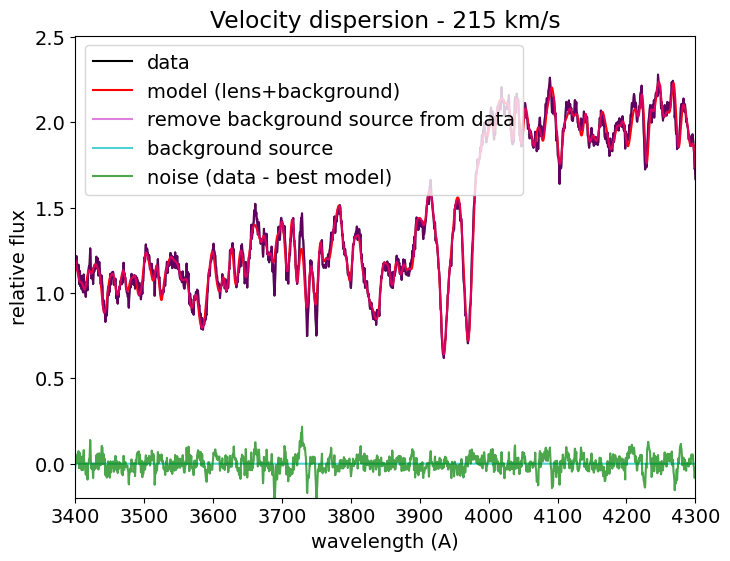

 Best Fit:       Vel     sigma
 comp.  0:       288       211
chi2/DOF: 16.38; DOF: 2017; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 18/629
Aperture VD 211.2151096552319
Formal errors:
     dV    dsigma   dh3      dh4
     2.8       3
Elapsed time in pPXF: 1.94 s


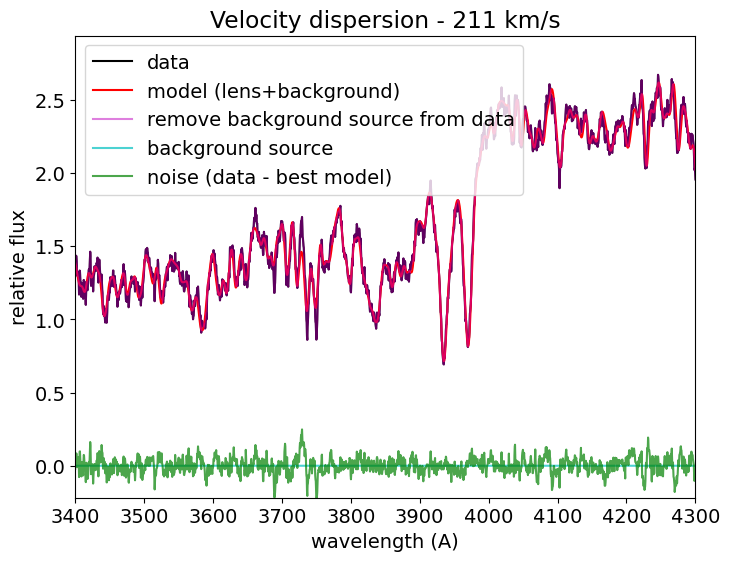

 Best Fit:       Vel     sigma
 comp.  0:       287       206
chi2/DOF: 20.84; DOF: 2017; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 17/629
Aperture VD 205.92210719107723
Formal errors:
     dV    dsigma   dh3      dh4
     2.8     3.1
Elapsed time in pPXF: 2.44 s


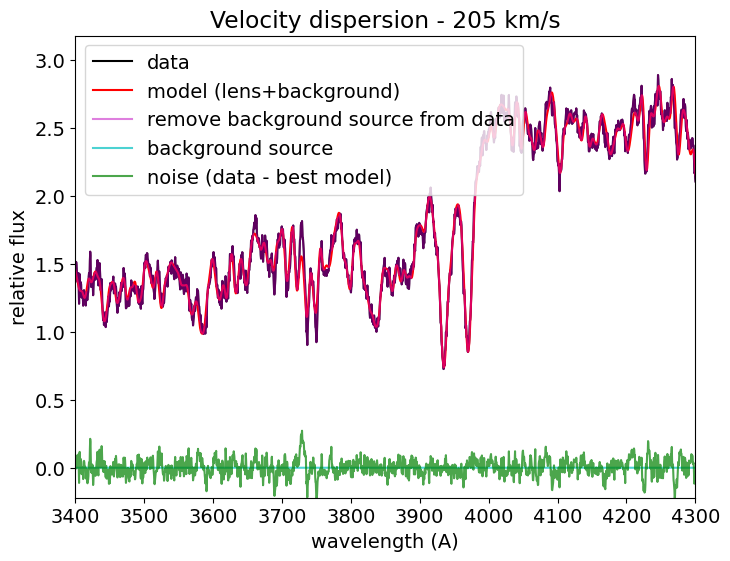

 Best Fit:       Vel     sigma
 comp.  0:       283       205
chi2/DOF: 22.16; DOF: 2017; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 16/629
Aperture VD 204.6439536204121
Formal errors:
     dV    dsigma   dh3      dh4
     2.9     3.2
Elapsed time in pPXF: 1.94 s


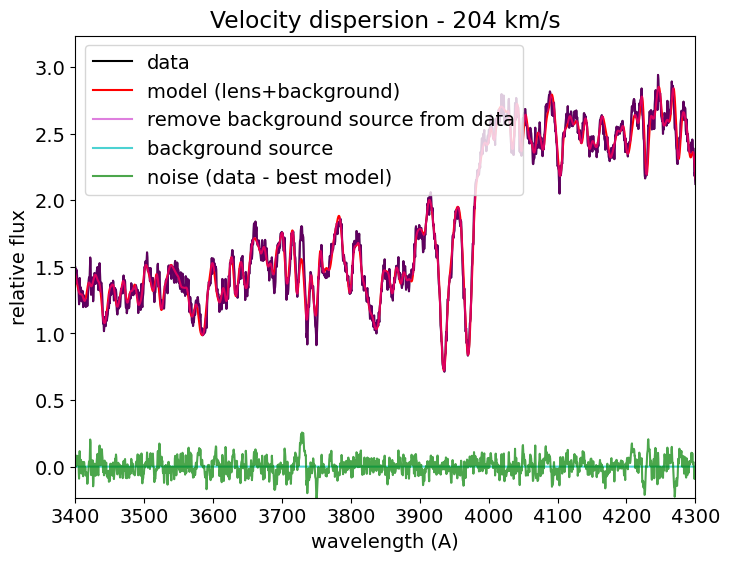

In [30]:
for aperture_factor in aperture_factors:
    reff = paper_table[paper_table['obj_name']==obj_name]['reff'].to_numpy()[0]
    aperture_radius = aperture_factor * reff
    pp_ap, VD_ap, dVD_ap = kin_data.extract_aperture_kinematics(data_seeing_FWHM=data_seeing_FWHM, 
                                                        simulated_seeing_FWHM=simulated_seeing_FWHM, 
                                                        aperture_radius=aperture_radius, 
                                                        convolve=convolve, 
                                                        fit_global_template=fit_global_template, 
                                                        plot=plot
                                                       )

In [68]:
VD_ap

215.1534070784799

In [ ]:
#squash

# Loop through all the objects and measure it

In [47]:
data_seeing_FWHM = 0#0.8 # arcsec
simulated_seeing_FWHM = 0#2.0
#aperture_radius = 1.5
convolve=False
fit_global_template=False
plot=False

In [48]:
aperture_factors = np.arange(0.1, 1.6, 0.1)

In [49]:
VD_apertures = np.ones((len(obj_names), len(aperture_factors)))

In [55]:
dVD_apertures = np.ones_like(VD_apertures)

In [56]:
for i, obj_name in enumerate(obj_names):

    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print()
    print(obj_name)
    print()
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    print('################################################################################################################')
    
    # get the effective radius
    reff = paper_table[paper_table['obj_name']==obj_name]['reff'].to_numpy()[0]
    
    # looop through all the aperture factors
    for j, factor in enumerate(aperture_factors):
        
        print()
        print('###############')
        print('aperture factor', factor)
        print()
        
        aperture_radius = factor * reff
        
        kin_dir = f'{kinematics_dir}{obj_name}/'

        # get the kinematics from the january date
        with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
            kin_data = pickle.load(file)

        # add the function to the class
        kin_data.extract_aperture_kinematics = MethodType(extract_aperture_kinematics, kin_data)

        # run the function
        pp_ap, VD_ap, dVD_ap = kin_data.extract_aperture_kinematics(data_seeing_FWHM=data_seeing_FWHM, 
                                                        simulated_seeing_FWHM=simulated_seeing_FWHM, 
                                                        aperture_radius=aperture_radius, 
                                                        convolve=convolve, 
                                                        fit_global_template=fit_global_template, 
                                                        plot=plot
                                                       )

        # save the VD
        VD_apertures[i, j] = VD_ap
        dVD_apertures[i, j] = dVD_ap

################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################
################################################################################################################

SDSSJ0029-0055

################################################################################################################
################################################################################################################
################################################################################################################
###############################################################################

In [57]:
# Take a look!
VD_apertures

array([[223.02585863, 223.66053509, 224.05340169, 220.59868833,
        216.86522859, 216.00490451, 214.94144225, 215.02683376,
        213.46160725, 211.21510966, 208.67912329, 207.14834973,
        204.98702172, 204.391197  , 204.64395362],
       [301.8079844 , 296.59526436, 296.33877549, 295.91363866,
        294.89664942, 293.15383785, 291.4233523 , 290.79835465,
        288.61739922, 287.42656621, 286.01823555, 284.77534589,
        282.28128777, 281.9515465 , 281.82708834],
       [242.19886559, 250.31142   , 254.7328234 , 259.94066065,
        266.06551988, 266.09317675, 264.1376347 , 261.94271438,
        259.61360964, 257.19531167, 256.01628931, 253.42265698,
        251.35061853, 250.63586615, 250.41756581],
       [295.9313467 , 297.95470614, 294.57554095, 292.30072336,
        291.97548926, 290.4779418 , 288.51167147, 287.09024747,
        287.07164348, 286.93757711, 287.12643332, 286.82661352,
        286.35245135, 286.28679847, 286.29775947],
       [281.23169977, 282.82

In [58]:
#quick! save it!

np.savetxt(f'{kinematics_dir}_cube_integrated_aperture_spectra_022724.txt', VD_apertures)
np.savetxt(f'{kinematics_dir}_cube_integrated_aperture_spectra_err_022724.txt', dVD_apertures)


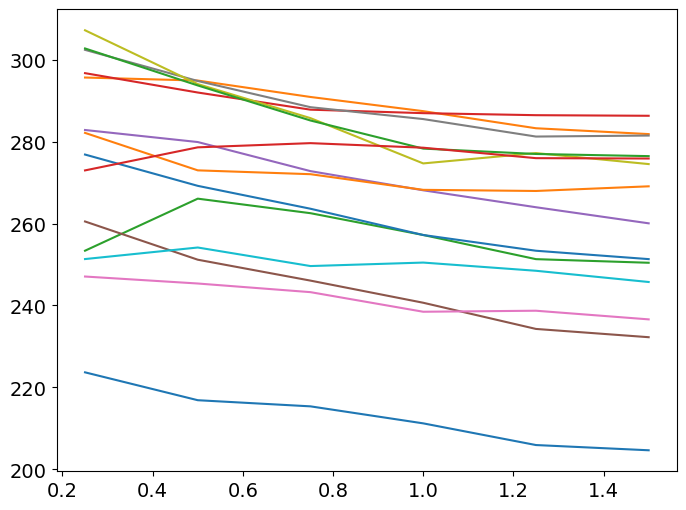

In [42]:
for i in range(14):
    plt.plot(aperture_factors, VD_apertures[i])

# Bring in the SDSS values

In [82]:
table_dir = f'{data_dir}tables/'

In [84]:
# 02/23/23 - Updated SLACS SDSS velocity dispersions
# asb is the label, unsure of meaning
hdul = fits.open(f'{table_dir}vdisp_slacs_asb.fits')
hdul.verify('fix')
data = hdul[1].data
header = hdul[1].header

# take the VD, dVD and SDSS names

VD_slacs_asb_data = data['VDISP_ASB']
dVD_slacs_asb_data = data['VDISP_ASB_ERR']
slacs_obj_names_data = data['SDSS_NAME']

VD_slacs_asb = np.ones_like(VD_apertures)
dVD_slacs_asb = np.ones_like(VD_apertures)

for i, obj_name in enumerate(obj_names):
    obj_index = np.argwhere(slacs_obj_names_data == obj_name)[0][0]
    VD = VD_slacs_asb_data[obj_index]
    dVD = dVD_slacs_asb_data[obj_index]
    
    VD_slacs_asb[i] = VD
    dVD_slacs_asb[i] = dVD
    


# Bring in the paper table for the effective radius

In [88]:
paper_table = pd.read_csv(f'{table_dir}paper_table_102023.csv')

In [89]:
reffs = paper_table.reff_slacs.to_numpy()

# Take at the effective radius and at half the effective radius

In [102]:
# collect the velocity disperions and error
VD_sdssaps = np.ones_like(VD_apertures)
VD_reffs = np.ones_like(VD_apertures)
VD_halfreffs = np.ones_like(VD_apertures)

dVD_sdssaps = np.ones_like(VD_apertures)
dVD_reffs = np.ones_like(VD_apertures)
dVD_halfreffs = np.ones_like(VD_apertures)

In [99]:
data_seeing_FWHM = 0.8 # arcsec
simulated_seeing_FWHM = 2.0
aperture_radius = 1.5
convolve=False
fit_global_template=False
plot=False

In [103]:
for i, obj_name in enumerate(obj_names):


    print('################################################################################################################')
    print()
    print(obj_name)
    print()
    print('effective radius', reffs[i])
    print()
    print('################################################################################################################')

    kin_dir = f'{kinematics_dir}{obj_name}/'

    # get the kinematics from the january date
    with open(f'{kin_dir}{obj_name}_kinematics_{sps_name}_{date_of_kin}.pkl', 'rb') as file:
        kin_data = pickle.load(file)
        
    # add the function to the class
    kin_data.extract_aperture_kinematics = MethodType(extract_aperture_kinematics, kin_data)
    
    # run the function for 1.5 arcsec aperture
    print('SDSS aperture')
    pp_sdssap, VD_sdssap, dVD_sdssap = kin_data.extract_aperture_kinematics(data_seeing_FWHM=data_seeing_FWHM, 
                                                    simulated_seeing_FWHM=simulated_seeing_FWHM, 
                                                    aperture_radius=reffs[i], 
                                                    convolve=True, 
                                                    fit_global_template=fit_global_template, 
                                                    plot=plot
                                                   )
    
    # run the function for reff
    print('reff')
    pp_reff, VD_reff, dVD_reff = kin_data.extract_aperture_kinematics(data_seeing_FWHM=data_seeing_FWHM, 
                                                    simulated_seeing_FWHM=simulated_seeing_FWHM, 
                                                    aperture_radius=reffs[i], 
                                                    convolve=False, 
                                                    fit_global_template=fit_global_template, 
                                                    plot=plot
                                                   )
    
    # run the function for half reff
    print('half reff')
    pp_halfreff, VD_halfreff, dVD_halfreff = kin_data.extract_aperture_kinematics(data_seeing_FWHM=data_seeing_FWHM, 
                                                    simulated_seeing_FWHM=simulated_seeing_FWHM, 
                                                    aperture_radius=reffs[i]/2, 
                                                    convolve=False, 
                                                    fit_global_template=fit_global_template, 
                                                    plot=plot
                                                   )
    
    # save the VD
    VD_sdssaps[i] = VD_sdssap
    VD_reffs[i] = VD_reff
    VD_halfreffs[i] = VD_halfreff
    # and error
    dVD_sdssaps[i] = dVD_sdssap
    dVD_reffs[i] = dVD_reff
    dVD_halfreffs[i] = dVD_halfreff

################################################################################################################

SDSSJ0029-0055

effective radius 2.3

################################################################################################################
SDSS aperture
Convolving with simulated seeing.
 Best Fit:       Vel     sigma
 comp.  0:       288       211
chi2/DOF: 16.18; DOF: 2017; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 18/629
Aperture VD 211.26494655997118
Formal errors:
     dV    dsigma   dh3      dh4
     2.7       3
Elapsed time in pPXF: 2.26 s
reff
 Best Fit:       Vel     sigma
 comp.  0:       288       211
chi2/DOF: 16.38; DOF: 2017; degree = 4; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 18/629
Aperture VD 211.2151096552319
Formal errors:
     dV    dsigma   dh3      dh4
     2.8       3
El

# Plot them!

In [107]:

SDSS_ap_ratios = VD_sdssaps/VD_slacs_asb
dSDSS_ap_ratios = SDSS_ap_ratios*np.sqrt((dVD_sdssaps/VD_sdssaps)**2+(dVD_slacs_asb/VD_slacs_asb)**2)

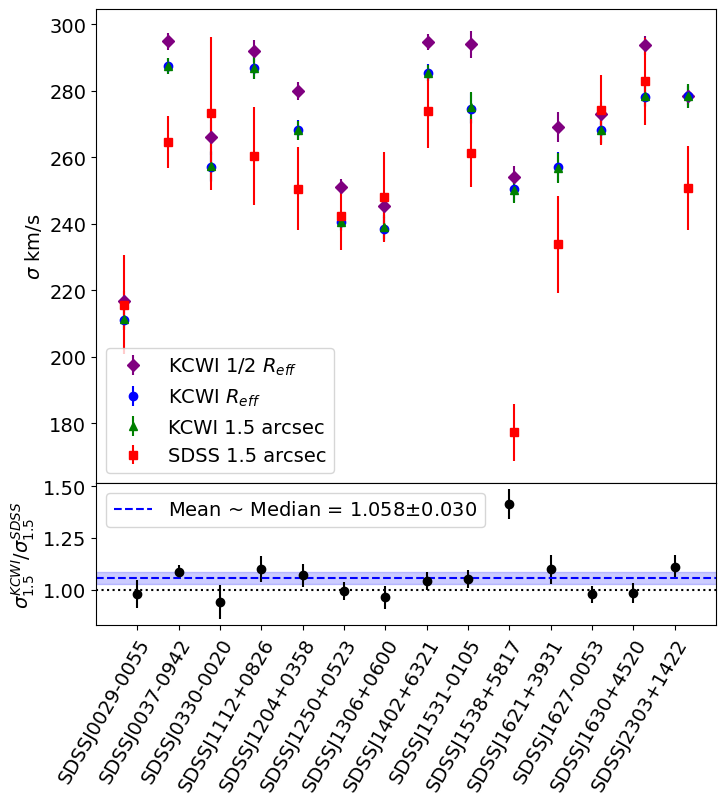

In [108]:
plt.rcParams.update({'font.size': 14})

mean = np.mean(SDSS_ap_ratios, axis=0)
err = np.std(SDSS_ap_ratios, axis=0)/np.sqrt(14)

fig, ax = plt.subplots(2,1,figsize=(8,8), gridspec_kw={'height_ratios': [10, 3]})
plt.subplots_adjust(hspace=0.0)

x = range(14)
ax[0].errorbar(x, VD_halfreffs[:], yerr=dVD_halfreffs[:], c='purple', marker='D', linestyle='')
ax[0].errorbar(x, VD_reffs[:], yerr=dVD_reffs[:], c='b', marker='o', linestyle='')
ax[0].errorbar(x, VD_sdssaps[:], yerr=dVD_sdssaps[:], c='g', marker='^', linestyle='')
ax[0].errorbar(x, VD_slacs_asb, yerr=dVD_slacs_asb, c='r', marker='s', linestyle='')
ax[0].legend([r'KCWI 1/2 $R_{eff}$', 'KCWI $R_{eff}$', r'KCWI 1.5 arcsec', 'SDSS 1.5 arcsec'], 
                   loc='lower left')#bbox_to_anchor=(0.1,0.3))
#ax[0].set_xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
ax[0].set_ylabel(r'$\sigma$ km/s')

x = np.linspace(-1, 15, 100)
ylo = np.ones_like(x)*(mean-err)
yhi = np.ones_like(x)*(mean+err)

for i in range(len(VD_slacs_asb)):
    ax[1].errorbar(i, SDSS_ap_ratios[i], yerr=dSDSS_ap_ratios[i], color='k', marker='o')
ax[1].set_ylabel(r'${\sigma_{1.5''}^{KCWI}}/{\sigma_{1.5''}^{SDSS}}$')
ax[1].axhline(mean, 0, 1, color='b', linestyle='--', label=f'Mean ~ Median = {"{:.3f}".format(mean)}$\pm${"{:.3f}".format(err)}')
ax[1].fill_between(x, 
                ylo,
               yhi,
               color='b',
               alpha=0.2)
ax[1].axhline(1.0, 0, 1, color='k', linestyle=':')
ax[1].set_xlim(-1, 14)
ax[1].set_xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
ax[1].legend(loc='upper left')
#ax[0].set_title(f'Bin S/N {vorbin_SN_targets[j]}')

#plt.savefig(f'{kinematics_dir}aperture_integrated_velocity_dispersions.pdf', bbox_inches='tight')
#plt.savefig(f'{kinematics_dir}aperture_integrated_velocity_dispersions.png', bbox_inches='tight')

In [109]:
np.nanmean(SDSS_ap_ratios[SDSS_ap_ratios < 1.25])

1.0308134851577102

In [164]:
np.nanstd(SDSS_ap_ratios[SDSS_ap_ratios < 1.25])

0.057204774654669034

Text(0.5, 0, 'Ratio KCWI/SDSS')

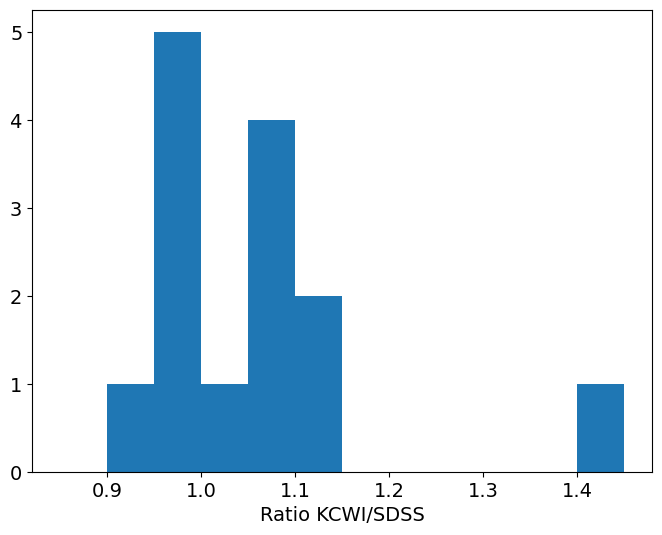

In [131]:
plt.hist(SDSS_ap_ratios, bins=np.arange(0.85, 1.5, 0.05))
plt.xlabel('Ratio KCWI/SDSS')

# Look at the half-reff from the map vs the datacube integration

In [144]:
VD_halfreffs_map = np.array([225.68243909, 289.49538815, 258.47557951, 293.61958435,
                           281.47536153, 254.40667434, 260.69891992, 301.9001231 ,
                           298.65960699, 254.15245899, 273.10634167, 280.12468598,
                           291.97673373, 274.33790698])

In [145]:
np.mean(VD_halfreffs/VD_halfreffs_map)

0.9906156084850793

In [146]:
np.std(VD_halfreffs/VD_halfreffs_map)

0.022550943017035134

Text(0.5, 0, 'Ratio')

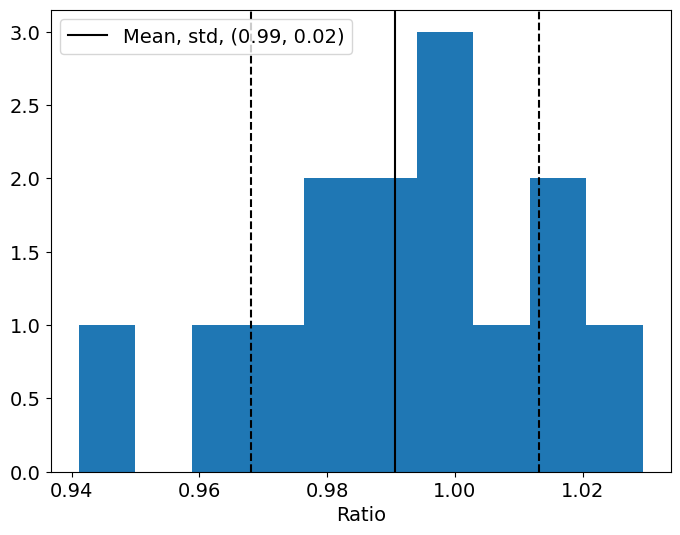

In [147]:
plt.hist(VD_halfreffs/VD_halfreffs_map)
plt.axvline(np.mean(VD_halfreffs/VD_halfreffs_map), linestyle='-', color='k', 
            label = f'Mean, std, {np.around(np.mean(VD_halfreffs/VD_halfreffs_map), 2),  np.around(np.std(VD_halfreffs/VD_halfreffs_map),2)}')
plt.axvline(np.mean(VD_halfreffs/VD_halfreffs_map-np.std(VD_halfreffs/VD_halfreffs_map)), linestyle='--', color='k')
plt.axvline(np.mean(VD_halfreffs/VD_halfreffs_map+np.std(VD_halfreffs/VD_halfreffs_map)), linestyle='--', color='k')
plt.legend()
plt.xlabel('Ratio')


(210.0, 300.0)

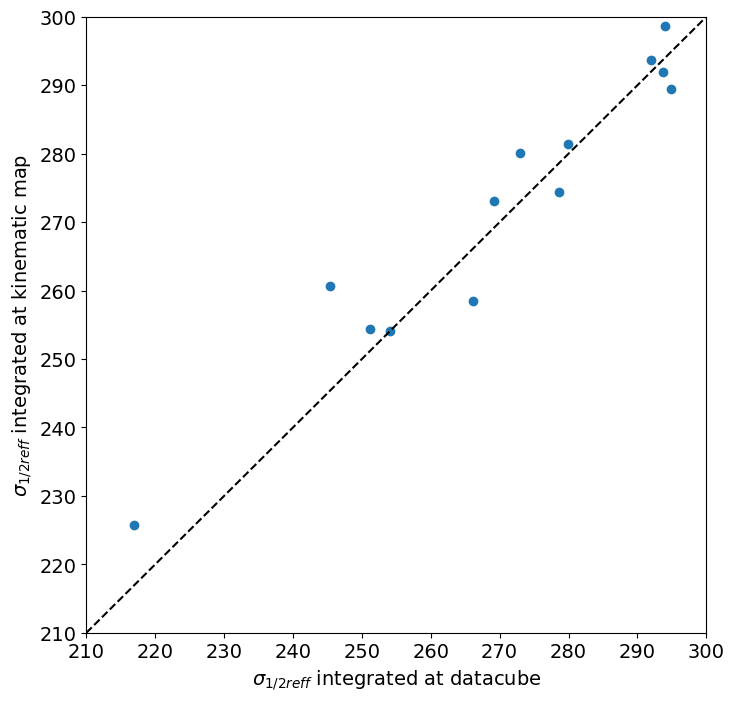

In [148]:
x = np.linspace(210, 300, 100)

plt.figure(figsize=(8,8))
plt.scatter(VD_halfreffs, VD_halfreffs_map)
plt.plot(x, x, 'k--')
plt.xlabel(r'$\sigma_{1/2 reff}$ integrated at datacube')
plt.ylabel(r'$\sigma_{1/2 reff}$ integrated at kinematic map')
plt.xlim(210, 300)
plt.ylim(210, 300)

# Now look at it within the effective radius

In [138]:
VD_reffs_map = np.array([218.68388824, 276.71858407, 250.93308242, 282.6829073 ,
                           272.31815826, 240.47292896, 249.62690893, 292.87860256,
                           289.67934157, 247.19159157, 258.55848245, 276.27584925,
                           277.26333028, 272.4353285 ])

In [139]:
np.mean(VD_reffs/VD_reffs_map)

0.9937746175248684

In [140]:
np.std(VD_reffs/VD_reffs_map)

0.02685475941234043

Text(0.5, 0, 'Ratio')

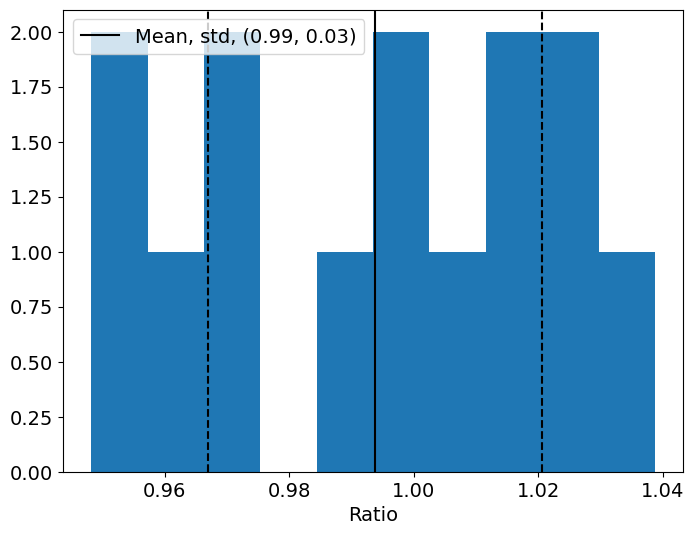

In [141]:
plt.hist(VD_reffs/VD_reffs_map)
plt.axvline(np.mean(VD_reffs/VD_reffs_map), linestyle='-', color='k', 
            label = f'Mean, std, {np.around(np.mean(VD_reffs/VD_reffs_map), 2),  np.around(np.std(VD_reffs/VD_reffs_map),2)}')
plt.axvline(np.mean(VD_reffs/VD_reffs_map-np.std(VD_reffs/VD_reffs_map)), linestyle='--', color='k')
plt.axvline(np.mean(VD_reffs/VD_reffs_map+np.std(VD_reffs/VD_reffs_map)), linestyle='--', color='k')
plt.legend()
plt.xlabel('Ratio')


(210.0, 300.0)

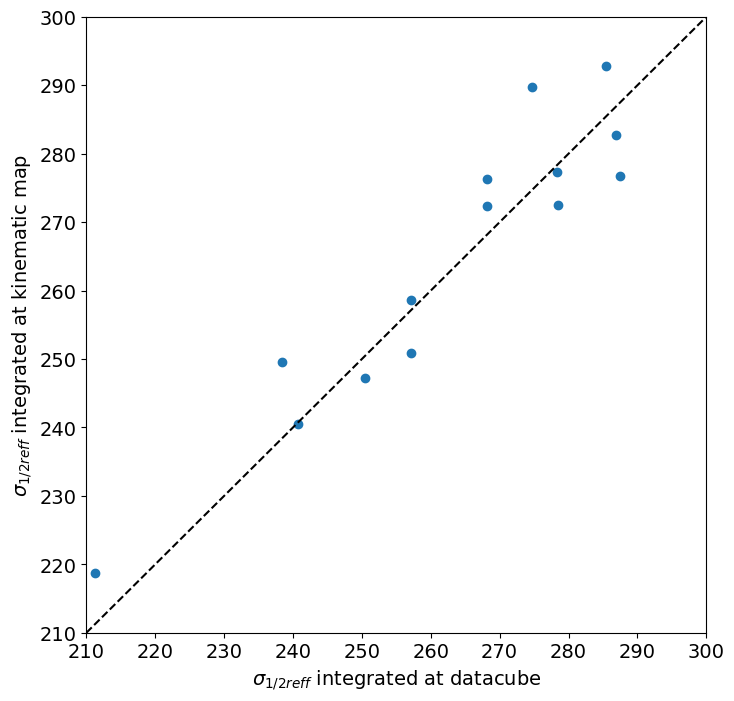

In [149]:
x = np.linspace(210, 300, 100)

plt.figure(figsize=(8,8))
plt.scatter(VD_reffs, VD_reffs_map)
plt.plot(x, x, 'k--')
plt.xlabel(r'$\sigma_{1/2 reff}$ integrated at datacube')
plt.ylabel(r'$\sigma_{1/2 reff}$ integrated at kinematic map')
plt.xlim(210, 300)
plt.ylim(210, 300)

In [ ]:
#squash

# Plot the aperture kinematics with the effective radius ones as the integrated versions and the SDSS ones as not.

In [142]:
dVD_halfreffs_map = np.array([ 8.11430629,  7.6432015 , 11.35453014,  6.11435321,  6.62578736,
                                6.16749561,  9.49209239,  7.89893599, 12.24349655,  6.30889517,
                               11.63024799, 12.60727202,  7.74785653, 10.53159455])

dVD_reffs_map = np.array([10.0381177 ,  8.89961147, 12.70941126,  7.38575054,  9.23677949,
                                7.79861751, 12.0823912 ,  9.23837187, 13.12354281,  8.82427908,
                               13.83060824, 17.49294946, 10.92515265, 11.50529183])

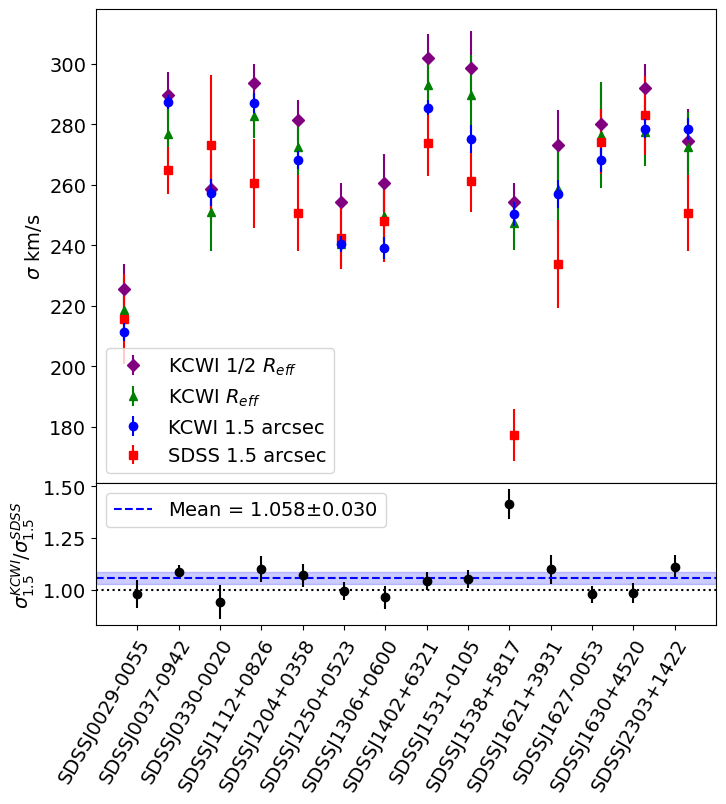

In [158]:
plt.rcParams.update({'font.size': 14})

mean = np.mean(SDSS_ap_ratios, axis=0)
err = np.std(SDSS_ap_ratios, axis=0)/np.sqrt(14)

fig, ax = plt.subplots(2,1,figsize=(8,8), gridspec_kw={'height_ratios': [10, 3]})
plt.subplots_adjust(hspace=0.0)

x = range(14)
ax[0].errorbar(x, VD_halfreffs_map[:], yerr=dVD_halfreffs_map[:], c='purple', marker='D', linestyle='')
ax[0].errorbar(x, VD_reffs_map[:], yerr=dVD_reffs_map[:], c='g', marker='^', linestyle='')
ax[0].errorbar(x, VD_sdssaps[:], yerr=dVD_sdssaps[:], c='b', marker='o', linestyle='', zorder=100)
ax[0].errorbar(x, VD_slacs_asb, yerr=dVD_slacs_asb, c='r', marker='s', linestyle='')
ax[0].legend([r'KCWI 1/2 $R_{eff}$', 'KCWI $R_{eff}$', r'KCWI 1.5 arcsec', 'SDSS 1.5 arcsec'], 
                   loc='lower left')#bbox_to_anchor=(0.1,0.3))
#ax[0].set_xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
ax[0].set_ylabel(r'$\sigma$ km/s')

x = np.linspace(-1, 15, 100)
ylo = np.ones_like(x)*(mean-err)
yhi = np.ones_like(x)*(mean+err)

for i in range(len(VD_slacs_asb)):
    ax[1].errorbar(i, SDSS_ap_ratios[i], yerr=dSDSS_ap_ratios[i], color='k', marker='o')
ax[1].set_ylabel(r'${\sigma_{1.5''}^{KCWI}}/{\sigma_{1.5''}^{SDSS}}$')
ax[1].axhline(mean, 0, 1, color='b', linestyle='--', label=f'Mean = {"{:.3f}".format(mean)}$\pm${"{:.3f}".format(err)}')
ax[1].fill_between(x, 
                ylo,
               yhi,
               color='b',
               alpha=0.2)
ax[1].axhline(1.0, 0, 1, color='k', linestyle=':')
ax[1].set_xlim(-1, 14)
ax[1].set_xticks(range(14), labels=obj_names, rotation=60, ha='right', rotation_mode='anchor')
ax[1].legend(loc='upper left')
#ax[0].set_title(f'Bin S/N {vorbin_SN_targets[j]}')

plt.savefig(f'{kinematics_dir}aperture_integrated_velocity_dispersions.pdf', bbox_inches='tight')
plt.savefig(f'{kinematics_dir}aperture_integrated_velocity_dispersions.png', bbox_inches='tight')

In [161]:
# Print the datacube-integrated vds to take over to the other analysis

In [160]:
VD_sdssaps

array([211.26494656, 287.41197403, 257.32492182, 286.95007795,
       268.09204097, 240.46467915, 239.0995199 , 285.49199042,
       275.06075138, 250.26083351, 256.90938286, 268.09459787,
       278.49342148, 278.39234733])

In [163]:
dVD_sdssaps

array([3.02051884, 2.32469061, 4.52272552, 3.25067286, 2.96761395,
       2.63192579, 3.67940682, 2.4222208 , 4.60764371, 3.87149718,
       4.4932315 , 3.98219001, 3.05359877, 3.67921924])

In [157]:
np.mean(SDSS_ap_ratios)

1.0580159773059774

In [156]:
np.median(SDSS_ap_ratios)

1.0475231650833674

(array([1., 5., 1., 5., 1., 0., 0., 0., 0., 1.]),
 array([0.92910634, 0.97705183, 1.02499733, 1.07294282, 1.12088832,
        1.16883382, 1.21677931, 1.26472481, 1.3126703 , 1.3606158 ,
        1.40856129]),
 <BarContainer object of 10 artists>)

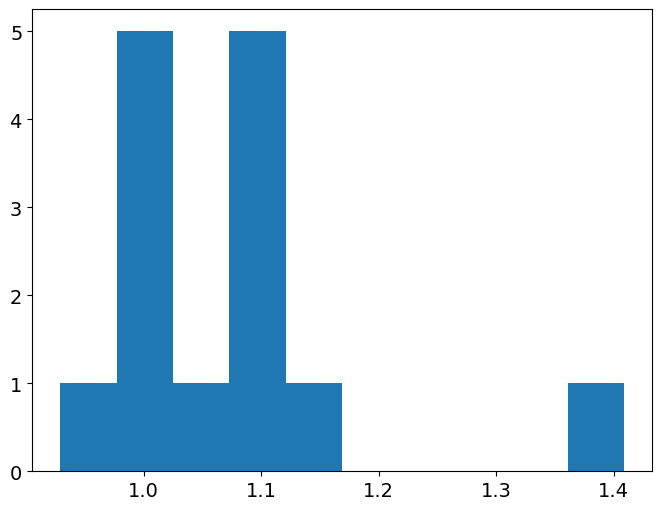

In [ ]:
plt.hist(VD_apertures/VD_slacs_asb)

(array([1., 0., 0., 2., 2., 0., 1., 2., 1., 5.]),
 array([215.15340708, 222.91872396, 230.68404084, 238.44935772,
        246.2146746 , 253.97999148, 261.74530836, 269.51062524,
        277.27594212, 285.041259  , 292.80657588]),
 <BarContainer object of 10 artists>)

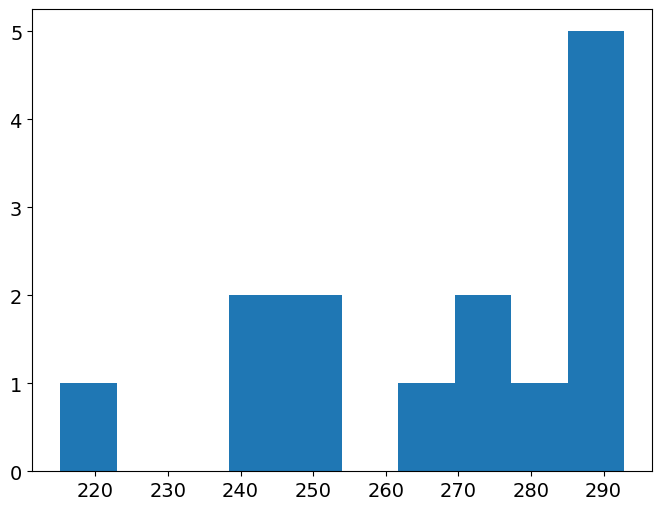

In [79]:
plt.hist(VD_apertures)